# Factor Analysis and Shared vs. Individual Variance on VMR Task

April 10, 2022

Athalye et al. 2017 reported changes in shared vs. private variance during long term learning (2 weeks), while Zippi et al. 2021 showed Factor Analysis differences between direct and indirect neurons

I wanted to approach some of these findings by applying Factor Analysis to different scenarios

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

### Train RNN on four targets

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### BPTT, RFLO and REINFORCE with the same parameters

18it [00:00, 179.35it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f8362f0acf0>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


2500it [00:07, 383.64it/s]


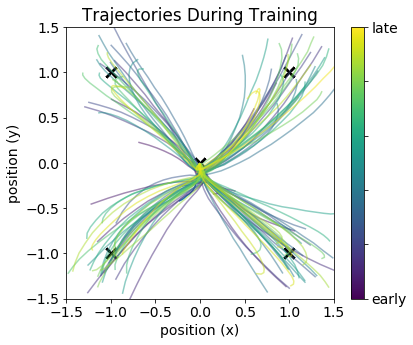

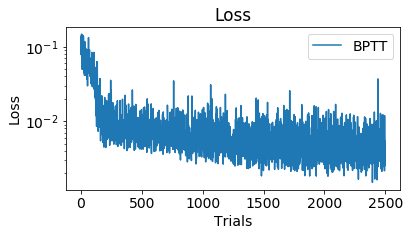

In [4]:
# Set RNN Parameters

params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01, sig_fb=0.01,
               velocity_transform=True, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(1991))
params.print_params()


# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
bptt = BPTT(net0,apply_to=['w_rec'],online=False) # something strange happening here
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','loss'], plot=True, plot_freq=20)




In [5]:
pr=[]
sh=[]
for h in sim0.session_probes['h']:
    fa = FactorAnalysis(n_components=2, random_state=0)
    fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

    private = np.sum(fa.noise_variance_)
    shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))
    
    pr.append(private)
    sh.append(shared)

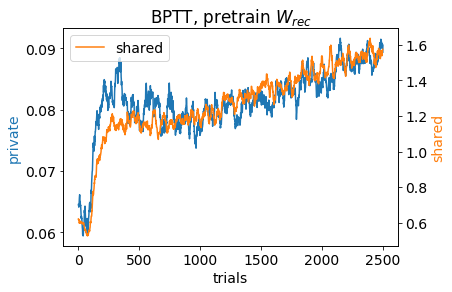

In [6]:
fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,25)
ax.plot(av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,25)
ax1.plot(av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('BPTT, pretrain '+r'$W_{rec}$')
plt.show()

# VMR Task

In [7]:
theta = np.pi/8
R = np.ones((2,2))
R[0,0]=np.cos(theta)
R[0,1]=-np.sin(theta)
R[1,0]=np.sin(theta)
R[1,1]=np.cos(theta)
task1r = Task(x_in=x_pulse1, y_target = R @ np.asarray([[1],[1]]))
task2r = Task(x_in=x_pulse2, y_target = R @ np.asarray([[-1],[1]]))
task3r = Task(x_in=x_pulse3, y_target = R @ np.asarray([[1],[-1]]))
task4r = Task(x_in=x_pulse4, y_target = R @ np.asarray([[-1],[-1]]))

29it [00:00, 286.13it/s]

apply_to :  ['w_fb']
online :  True
weight_transport :  True


5000it [00:10, 464.86it/s]


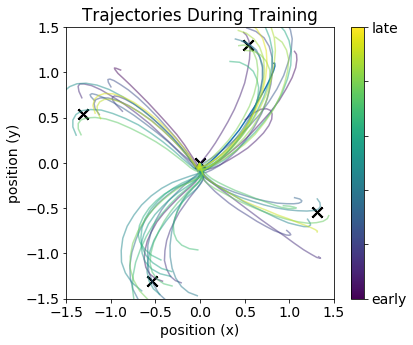

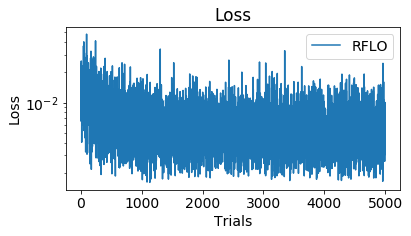

In [8]:
# Set RNN Parameters


# Initialize RNN
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_out=net0.w_out.copy(),w_fb=net0.w_fb.copy())
sim1 = Simulation(net1)

rflo = RFLO(net1,apply_to=['w_fb']) 
rflo.print_params()
sim1.run_session(n_trials=5000, tasks=[task1r,task2r,task3r,task4r], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=100)


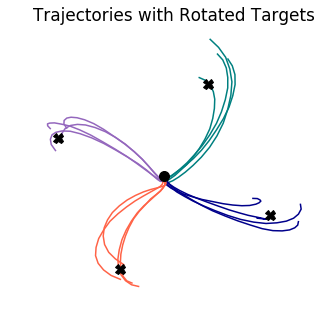

In [9]:
fig = plot_trained_trajectories(sim=sim1, tasks=[task1r,task2r,task3r,task4r],title='Trajectories with Rotated Targets')


In [10]:
pr=[]
sh=[]
for h in sim1.session_probes['h']:
    fa = FactorAnalysis(n_components=2, random_state=0)
    fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

    private = np.sum(fa.noise_variance_)
    shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))
    
    pr.append(private)
    sh.append(shared)

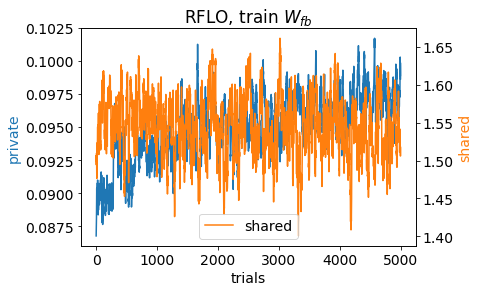

In [11]:
fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,25)
ax.plot(av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,25)
ax1.plot(av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('RFLO, train '+r'$W_{fb}$')
plt.show()

### It seems that when the upstream weights change, there is no difference in Factor Analysis over time. However, when the recurrent weights change, we do see a change in the Factor Analysis

12it [00:00, 118.24it/s]

apply_to :  ['w_rec']
online :  True
weight_transport :  True


2500it [00:11, 221.61it/s]


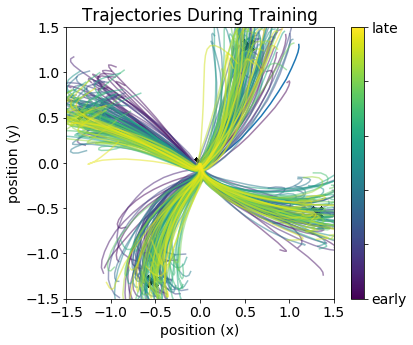

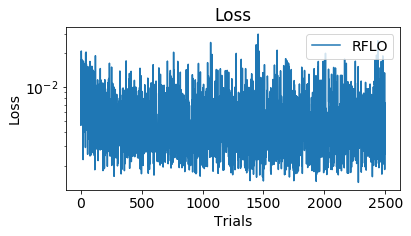

In [12]:

# Initialize RNN
net2 = RNN(params)
net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_out=net0.w_out.copy(),w_fb=net0.w_fb.copy())
sim2 = Simulation(net2)

rflo = RFLO(net2,apply_to=['w_rec']) 
rflo.print_params()
sim2.run_session(n_trials=2500, tasks=[task1r,task2r,task3r,task4r], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=5)


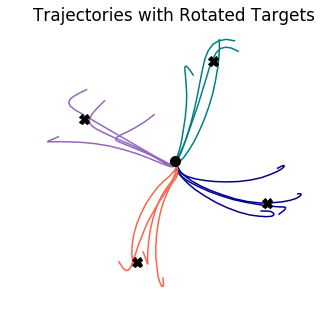

In [13]:
fig = plot_trained_trajectories(sim=sim2, tasks=[task1r,task2r,task3r,task4r],title='Trajectories with Rotated Targets')


In [14]:
pr=[]
sh=[]
for h in sim2.session_probes['h']:
    fa = FactorAnalysis(n_components=2, random_state=0)
    fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

    private = np.sum(fa.noise_variance_)
    shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))
    
    pr.append(private)
    sh.append(shared)

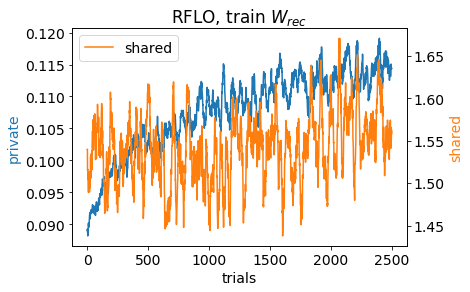

In [15]:
fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,25)
ax.plot(av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,25)
ax1.plot(av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('RFLO, train '+r'$W_{rec}$')
plt.show()

# REINFORCE, train W_fb

13it [00:00, 125.80it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f834d0d0438>
apply_to :  ['w_fb']
online :  True


50000it [02:00, 415.26it/s]


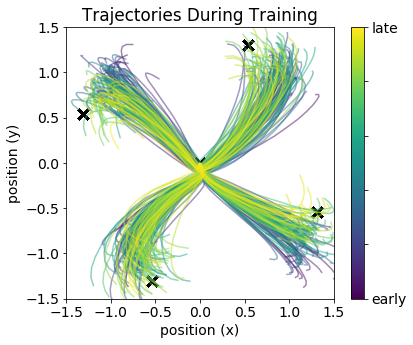

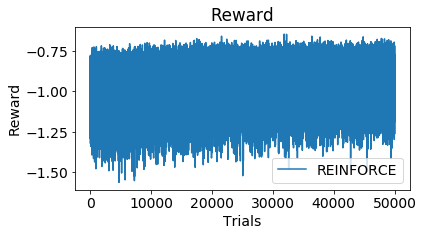

In [16]:
# Initialize RNN
params.print_params()
net4 = RNN(params)
net4.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_out=net0.w_out.copy(),w_fb=net0.w_fb.copy())
sim4 = Simulation(net4)

reinforce = REINFORCE(net4,apply_to=['w_fb'],tau_reward=5) 
reinforce.print_params()
sim4.run_session(n_trials=50000, tasks=[task1r,task2r,task3r,task4r], learn_alg=[reinforce], probe_types=['h'], plot=True, plot_freq=100)


In [17]:
pr=[]
sh=[]
for h in sim4.session_probes['h']:
    fa = FactorAnalysis(n_components=2, random_state=0)
    fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

    private = np.sum(fa.noise_variance_)
    shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))
    
    pr.append(private)
    sh.append(shared)

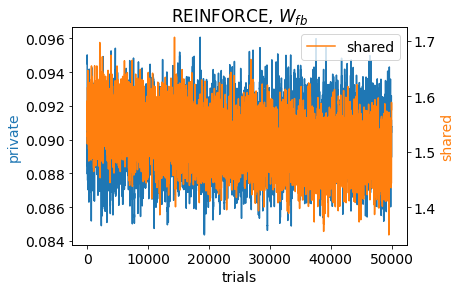

In [18]:
fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,25)
ax.plot(av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,25)
ax1.plot(av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('REINFORCE, '+'$W_{fb}$')
plt.show()

# REINFORCE, train w_rec

33it [00:00, 327.72it/s]

apply_to :  ['w_rec']
online :  True


10000it [00:28, 355.44it/s]


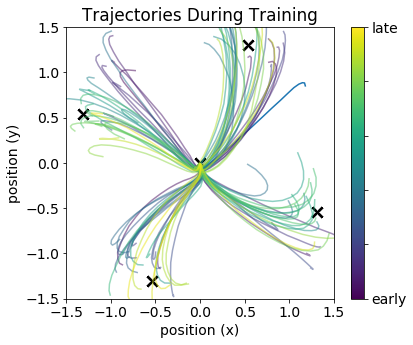

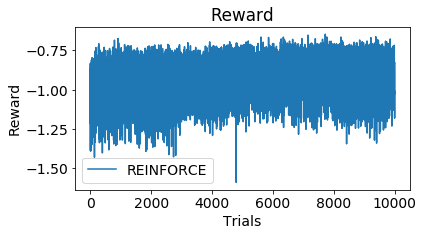

In [19]:


# Initialize RNN
net3 = RNN(params)
net3.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_out=net0.w_out.copy(),w_fb=net0.w_fb.copy())
sim3 = Simulation(net3)

reinforce = REINFORCE(net3,apply_to=['w_rec'],tau_reward=5) 
reinforce.print_params()
sim3.run_session(n_trials=10000, tasks=[task1r,task2r,task3r,task4r], learn_alg=[reinforce], probe_types=['h'], plot=True, plot_freq=100)


In [20]:
pr=[]
sh=[]
for h in sim3.session_probes['h']:
    fa = FactorAnalysis(n_components=2, random_state=0)
    fa.fit(h.squeeze()) # X array-like, shape (n_samples, n_features)

    private = np.sum(fa.noise_variance_)
    shared = np.sum(np.diag(np.dot(fa.components_,fa.components_.T)))
    
    pr.append(private)
    sh.append(shared)

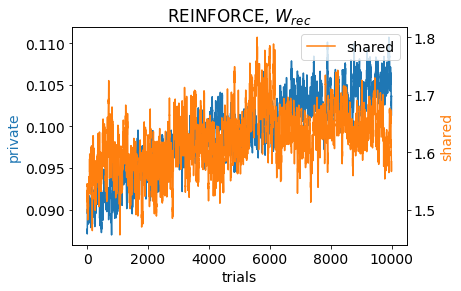

In [21]:
fig,ax = plt.subplots(1,1)
ax1=ax.twinx()
av_pr = uniform_filter1d(pr,25)
ax.plot(av_pr,label='private',color='C0')
ax.set_ylabel('private',color='C0')

av_sh = uniform_filter1d(sh,25)
ax1.plot(av_sh,label='shared',color='C1')
ax1.set_ylabel('shared',color='C1')
ax.set_xlabel('trials')
ax1.legend()
plt.title('REINFORCE, '+'$W_{rec}$')
plt.show()